## 1. Environment configuration and library import

In [1]:
# HuggingFace image Source Configuration (Accelerated Download for Chinese users)
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["HF_HOME"] = "./hf_cache"
os.environ["WANDB_DISABLED"] = "true"

import warnings
warnings.filterwarnings('ignore')

print("Environment configuration completed")
print(f"HF image source: {os.environ.get('HF_ENDPOINT')}")

Environment configuration completed
HF image source: https://hf-mirror.com


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import json
from datetime import datetime

# HuggingFace related libraries
from datasets import load_dataset
from transformers import (
    ViTFeatureExtractor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_metric

# PyTorch data processing
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop, Compose, RandomHorizontalFlip,
    RandomResizedCrop, Resize
)

# Evaluation indexes from scikit-learn
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)

print("All libraries have been imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"GPU model: {torch.cuda.get_device_name(0)}")
    print(f"Memory size: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

All libraries have been imported successfully
PyTorch version: 2.1.2+cu121
Using device: GPU
GPU model: NVIDIA GeForce RTX 4090
Memory size: 23 GB


## 2. Configuration parameters

In [3]:
# CIFAR-10 Category label
LABELNAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
              'dog', 'frog', 'horse', 'ship', 'truck']
NUM_LABELS = len(LABELNAMES)

# Model configuration
MODEL_NAME = 'google/vit-base-patch16-224-in21k'
OUTPUT_DIR = "./vit-cifar10-results"

# Training parameters
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 8

# Create an output directory if it doesn't exist
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Configuration parameters:")
print(f"model: {MODEL_NAME}")
print(f"number of categories: {NUM_LABELS}")
print(f"number of epochs: {NUM_EPOCHS}")
print(f"learning rate: {LEARNING_RATE}")
print(f"batch size: {TRAIN_BATCH_SIZE}")
print(f"output directory: {OUTPUT_DIR}")

Configuration parameters:
model: google/vit-base-patch16-224-in21k
number of categories: 10
number of epochs: 5
learning rate: 2e-05
batch size: 16
output directory: ./vit-cifar10-results


## 3. Dataset loading

In [4]:
# Load the CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")

try:
    # Load dataset from HuggingFace
    train_data, test_data = load_dataset('cifar10', split=['train', 'test'])
    
    # Split training and validation sets
    splits = train_data.train_test_split(test_size=0.1, seed=42)
    train_data = splits['train']
    val_data = splits['test']
    
    print("Dataset loaded successfully!")
    print(f"Training set: {len(train_data)} samples")
    print(f"Validation set: {len(val_data)} samples")
    print(f"Test set: {len(test_data)} samples")
    
except Exception as e:
    print(f"Failed to load dataset: {e}")
    raise

Loading CIFAR-10 dataset...
Dataset loaded successfully!
Training set: 45000 samples
Validation set: 5000 samples
Test set: 10000 samples


## 4. Data visualization analysis

Displaying CIFAR-10 dataset samples:


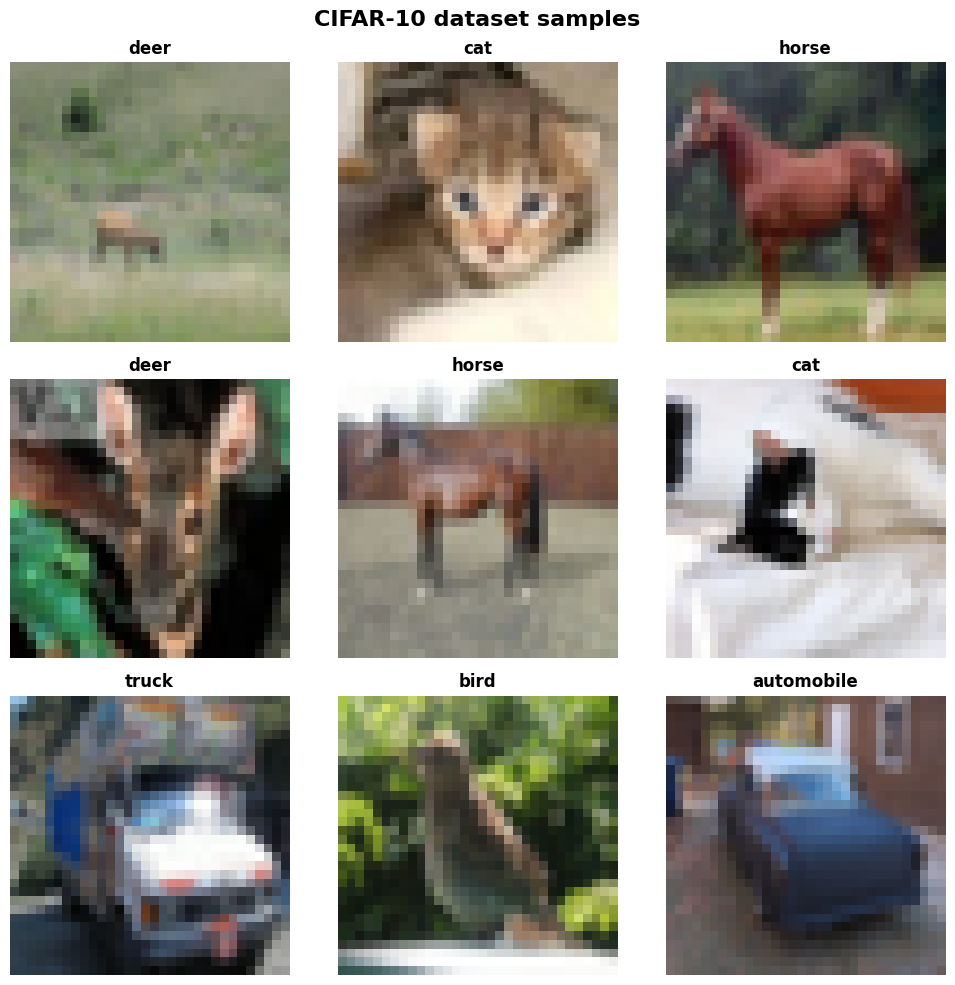

In [5]:
# Display the sample of the dataset
print("Displaying CIFAR-10 dataset samples:")

num_samples = 9
images = train_data[0:num_samples]['img']
labels = train_data[0:num_samples]['label']
titles = [LABELNAMES[label] for label in labels]

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()

for img, title, ax in zip(images, titles, axs):
    ax.imshow(img)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle('CIFAR-10 dataset samples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

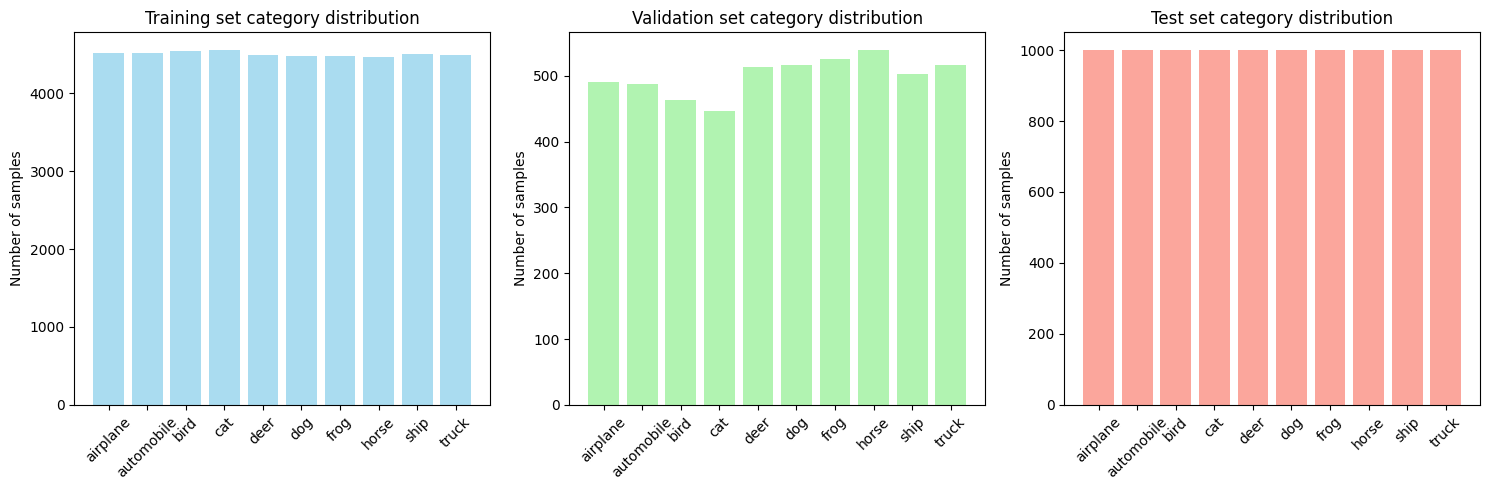

Dataset category distribution statistics:
Training set sample counts: [4510 4513 4537 4553 4487 4483 4474 4461 4498 4484]
Validation set sample counts: [490 487 463 447 513 517 526 539 502 516]
Test set sample counts: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [6]:
# Statistical analysis of the dataset
train_labels = train_data['label']
val_labels = val_data['label']
test_labels = test_data['label']

# Calculate the distribution of each category
train_counts = np.bincount(train_labels)
val_counts = np.bincount(val_labels)
test_counts = np.bincount(test_labels)

# Plot the category distribution charts
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Training set distribution
axes[0].bar(LABELNAMES, train_counts, color='skyblue', alpha=0.7)
axes[0].set_title('Training set category distribution')
axes[0].set_ylabel('Number of samples')
axes[0].tick_params(axis='x', rotation=45)

# Validation set distribution
axes[1].bar(LABELNAMES, val_counts, color='lightgreen', alpha=0.7)
axes[1].set_title('Validation set category distribution')
axes[1].set_ylabel('Number of samples')
axes[1].tick_params(axis='x', rotation=45)

# Test set distribution
axes[2].bar(LABELNAMES, test_counts, color='salmon', alpha=0.7)
axes[2].set_title('Test set category distribution')
axes[2].set_ylabel('Number of samples')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Dataset category distribution statistics:")
print(f"Training set sample counts: {train_counts}")
print(f"Validation set sample counts: {val_counts}")
print(f"Test set sample counts: {test_counts}")

## 5. Model configuration and data preprocessing

In [7]:
# Initialize the ViT feature extractor
print("Initializing ViT feature extractor...")

feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_NAME)

# Get image size
if isinstance(feature_extractor.size, dict):
    img_size = feature_extractor.size.get('height', 224)
else:
    img_size = feature_extractor.size

print("Feature extractor configuration:")
print(f"Image size: {img_size}x{img_size}")
print(f"Image mean: {feature_extractor.image_mean}")
print(f"Image std: {feature_extractor.image_std}")

Initializing ViT feature extractor...
Feature extractor configuration:
Image size: 224x224
Image mean: [0.5, 0.5, 0.5]
Image std: [0.5, 0.5, 0.5]


In [8]:
# Configuration data transformation
print("Configuring data transformation...")

# Data augmentation during training
train_transforms = Compose([
    RandomResizedCrop(img_size),
    RandomHorizontalFlip(p=0.5),
])

# Data transformation during validation/testing
val_transforms = Compose([
    Resize(img_size),
    CenterCrop(img_size),
])

def train_transform(batch):
    """Training set transformation function"""
    transformed_images = [train_transforms(x.convert("RGB")) for x in batch['img']]
    inputs = feature_extractor(transformed_images, return_tensors='pt')
    inputs['labels'] = batch['label']
    return inputs

def val_transform(batch):
    """Validation/testing set transformation function"""
    transformed_images = [val_transforms(x.convert("RGB")) for x in batch['img']]
    inputs = feature_extractor(transformed_images, return_tensors='pt')
    inputs['labels'] = batch['label']
    return inputs

print("Data transformation configuration completed")

Configuring data transformation...
Data transformation configuration completed


In [9]:
# Application data transformation
print("Applying data transformation to datasets...")

train_data.set_transform(train_transform)
val_data.set_transform(val_transform)
test_data.set_transform(val_transform)

print("Data transformation application completed")

Applying data transformation to datasets...
Data transformation application completed


## 6. Model initialization

In [10]:
# Load the pre-trained ViT model
print("Initializing ViT model...")

model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)

print("Model configuration:")
print(f"Model type: {type(model).__name__}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Number of output classes: {NUM_LABELS}")

Initializing ViT model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model configuration:
Model type: ViTForImageClassification
Total parameters: 85,806,346
Trainable parameters: 85,806,346
Number of output classes: 10


In [11]:
# Visual analysis of model architecture
print("\nModel architecture analysis:")
print("Main components:")

for name, module in model.named_children():
    if hasattr(module, '__len__') and len(list(module.parameters())) > 0:
        param_count = sum(p.numel() for p in module.parameters())
        print(f"  {name}: {param_count:,} parameters")
    elif len(list(module.parameters())) > 0:
        param_count = sum(p.numel() for p in module.parameters())
        print(f"  {name}: {param_count:,} parameters")

# Check the classifier head
if hasattr(model, 'classifier'):
    classifier_params = sum(p.numel() for p in model.classifier.parameters())
    print(f"\nClassifier head parameters: {classifier_params:,}")
    print(f"Classifier structure: {model.classifier}")


Model architecture analysis:
Main components:
  vit: 85,798,656 parameters
  classifier: 7,690 parameters

Classifier head parameters: 7,690
Classifier structure: Linear(in_features=768, out_features=10, bias=True)


## 7. Training configuration

In [12]:
# Define the calculation function of the evaluation index
def compute_metrics(eval_pred):
    """Calculate evaluation metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    try:
        try:
            import evaluate
            metric = evaluate.load("accuracy")
        except ImportError:
            metric = load_metric("accuracy")
        return metric.compute(predictions=predictions, references=labels)
    except Exception as e:
        # Fallback: manual calculation
        accuracy = (predictions == labels).mean()
        return {'accuracy': accuracy}

# Data batch processing function
def collate_fn(batch):
    """Data batch processing function"""
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

print("Evaluation function and data processing function definition completed")

Evaluation function and data processing function definition completed


In [13]:
# Training configuration
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_dir=f'{OUTPUT_DIR}/logs',
    logging_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    fp16=True,  # Mixed precision training
    seed=42,
)

print("Training configuration:")
print(f"EPOCH: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Training batch size: {TRAIN_BATCH_SIZE}")
print(f"Evaluation batch size: {EVAL_BATCH_SIZE}")
print(f"Weight decay: 0.01")
print(f"Mixed precision: Enabled")
print(f"Output directory: {OUTPUT_DIR}")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training configuration:
EPOCH: 5
Learning rate: 2e-05
Training batch size: 16
Evaluation batch size: 8
Weight decay: 0.01
Mixed precision: Enabled
Output directory: ./vit-cifar10-results


## 8. Model training

In [14]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=feature_extractor,
)

print("Trainer initialization completed")
print(f"Training dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print("Ready to start training...")

Trainer initialization completed
Training dataset size: 45000
Validation dataset size: 5000
Ready to start training...


In [15]:
# Execute training
print("Starting ViT model training...")

start_time = datetime.now()
print(f"Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# Execute training
train_results = trainer.train()

end_time = datetime.now()
duration = end_time - start_time

print("Training completed!")
print(f"End time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total duration: {duration}")
print(f"Final training loss: {train_results.training_loss:.4f}")

Starting ViT model training...
Start time: 2025-11-26 22:33:10


Epoch,Training Loss,Validation Loss,Accuracy
1,0.357100,0.100303,0.982000
2,0.216300,0.053794,0.988200
3,0.230800,0.044969,0.988400
4,0.189200,0.041052,0.989800
5,0.182900,0.038466,0.989400


Training completed!
End time: 2025-11-26 23:11:10
Total duration: 0:37:59.264159
Final training loss: 0.2909


In [16]:
# Save the trained model
print("Saving the trained model...")

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

print(f"Model saved to: {OUTPUT_DIR}")
print("Training phase completed!")

Saving the trained model...
***** train metrics *****
  epoch                    =           5.0
  total_flos               = 16239423145GF
  train_loss               =        0.2909
  train_runtime            =    0:37:59.08
  train_samples_per_second =        98.724
  train_steps_per_second   =         6.171
Model saved to: ./vit-cifar10-results
Training phase completed!


## 9. Visualization of the training process

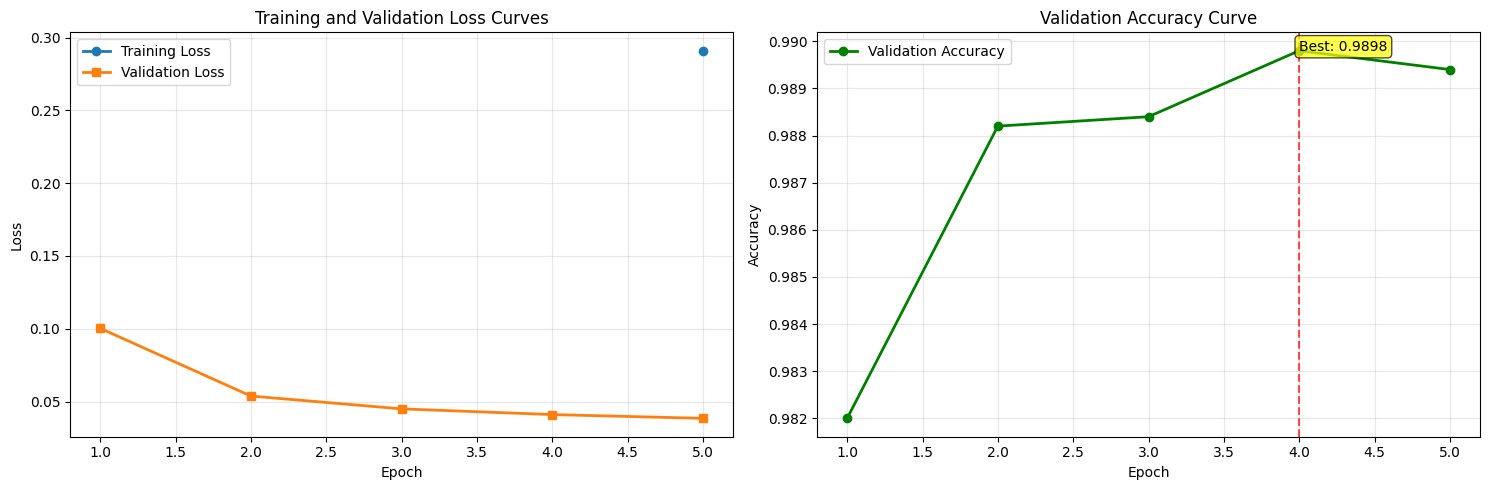

Training process visualization completed
Best validation accuracy: 0.9898
Final validation accuracy: 0.9894


In [17]:
# Visualize training process
import json
from pathlib import Path

log_history = trainer.state.log_history

# Extract training and validation metrics
train_loss = []
eval_loss = []
eval_accuracy = []
epochs = []

for log in log_history:
    if 'train_loss' in log:
        train_loss.append(log['train_loss'])
        if 'epoch' in log:
            epochs.append(log['epoch'])
    
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
if len(epochs) == len(train_loss) and len(eval_loss) > 0:
    axes[0].plot(epochs, train_loss, label='Training Loss', marker='o', linewidth=2)
    eval_epochs = range(1, len(eval_loss) + 1)
    axes[0].plot(eval_epochs, eval_loss, label='Validation Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Accuracy curves
if len(eval_accuracy) > 0:
    eval_epochs = range(1, len(eval_accuracy) + 1)
    axes[1].plot(eval_epochs, eval_accuracy, label='Validation Accuracy', marker='o', color='green', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Validation Accuracy Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Mark the best performance point
    best_acc_epoch = np.argmax(eval_accuracy) + 1
    best_accuracy = max(eval_accuracy)
    axes[1].axvline(x=best_acc_epoch, color='red', linestyle='--', alpha=0.7)
    axes[1].text(best_acc_epoch, best_accuracy, f'Best: {best_accuracy:.4f}', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training process visualization completed")
if eval_accuracy:
    print(f"Best validation accuracy: {max(eval_accuracy):.4f}")
    print(f"Final validation accuracy: {eval_accuracy[-1]:.4f}")

## 10. Model evaluation

In [18]:
# Evaluate model performance on the test set
print("Evaluating model performance on the test set...")

# Make predictions
predictions = trainer.predict(test_data)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print(f"Number of test samples: {len(y_true)}")
print("Prediction completed")

Evaluating model performance on the test set...


Number of test samples: 10000
Prediction completed


In [19]:
# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test set performance metrics:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nDetailed performance by class:")
report = classification_report(y_true, y_pred, target_names=LABELNAMES, digits=4)
print(report)

Test set performance metrics:
Accuracy: 0.9872 (98.72%)
Precision: 0.9872
Recall: 0.9872
F1 Score: 0.9872

Detailed performance by class:
              precision    recall  f1-score   support

    airplane     0.9920    0.9960    0.9940      1000
  automobile     0.9812    0.9920    0.9866      1000
        bird     0.9900    0.9890    0.9895      1000
         cat     0.9625    0.9740    0.9682      1000
        deer     0.9880    0.9900    0.9890      1000
         dog     0.9797    0.9660    0.9728      1000
        frog     0.9950    0.9970    0.9960      1000
       horse     0.9970    0.9940    0.9955      1000
        ship     0.9960    0.9920    0.9940      1000
       truck     0.9909    0.9820    0.9864      1000

    accuracy                         0.9872     10000
   macro avg     0.9872    0.9872    0.9872     10000
weighted avg     0.9872    0.9872    0.9872     10000



## 11. Visual analysis of results

<Figure size 1200x1000 with 0 Axes>

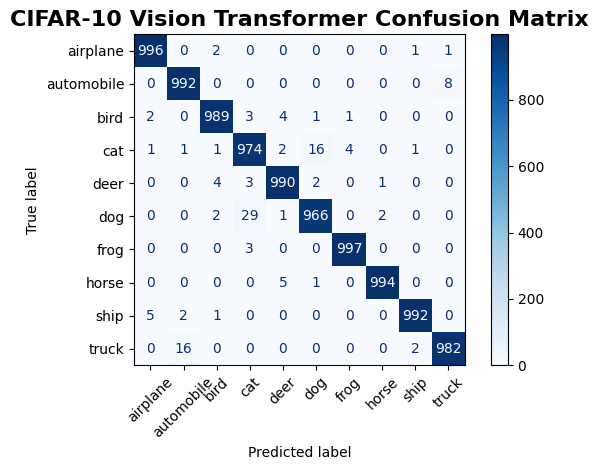

Confusion matrix generation completed


In [20]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELNAMES)
disp.plot(cmap='Blues', values_format='d')
plt.title('CIFAR-10 Vision Transformer Confusion Matrix', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix generation completed")

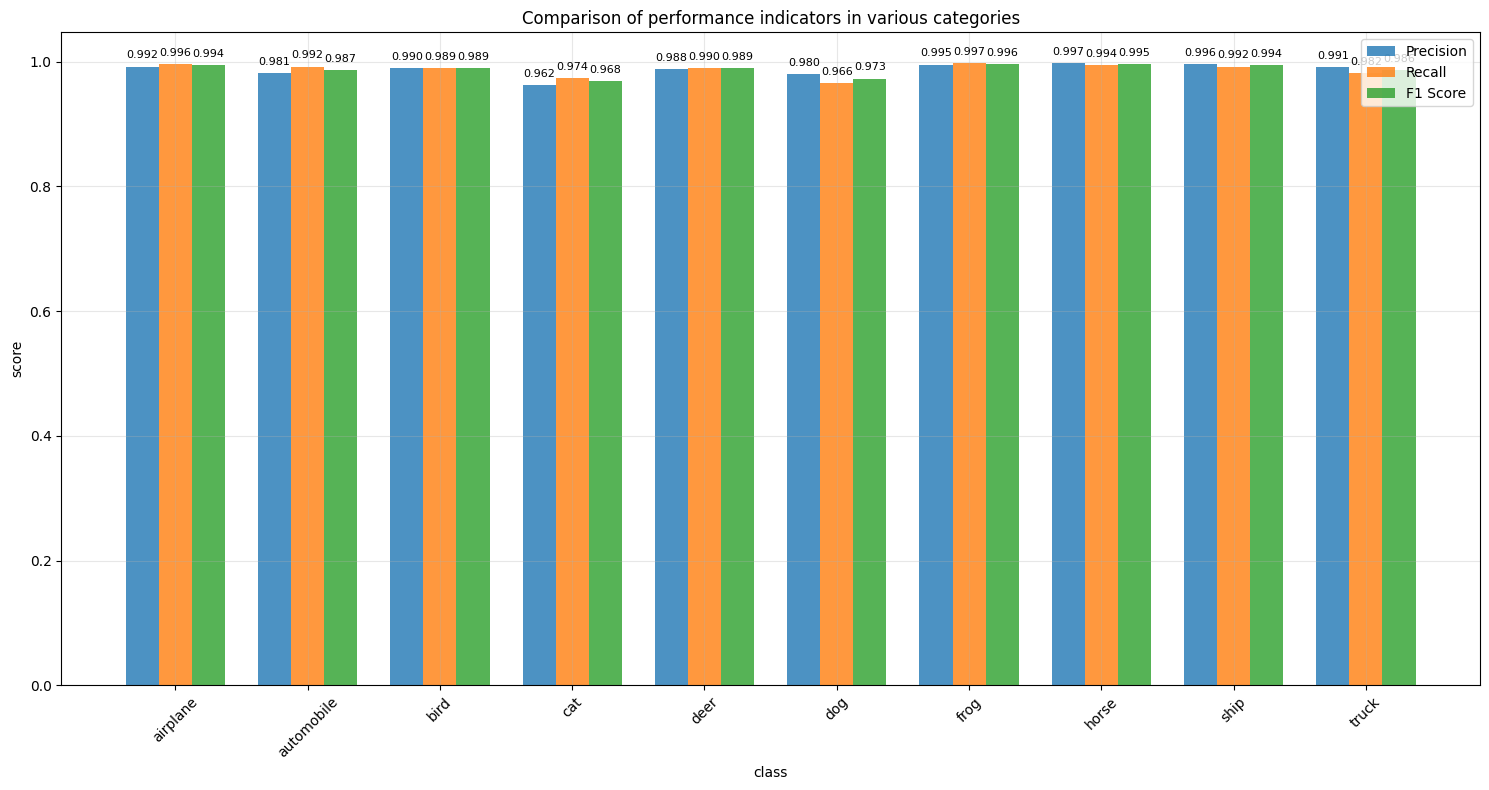

completed


In [21]:
# Detailed class performance visualization
from sklearn.metrics import classification_report

# Get class-wise metrics
report_dict = classification_report(y_true, y_pred, target_names=LABELNAMES, output_dict=True)

# Extract precision, recall, and F1-score for each class
categories = LABELNAMES
precision_scores = [report_dict[cat]['precision'] for cat in categories]
recall_scores = [report_dict[cat]['recall'] for cat in categories]
f1_scores = [report_dict[cat]['f1-score'] for cat in categories]

# Plot class-wise performance comparison
x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 8))
bars1 = ax.bar(x - width, precision_scores, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall_scores, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1_scores, width, label='F1 Score', alpha=0.8)

ax.set_xlabel('class')
ax.set_ylabel('score')
ax.set_title('Comparison of performance indicators in various categories')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/class_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("completed")

## 12. Result saving

In [23]:
# save complete evaluation results
results = {
    'model_name': MODEL_NAME,
    'test_accuracy': float(accuracy),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1': float(f1),
    'num_test_samples': len(test_data),
    'training_params': {
        'num_epochs': NUM_EPOCHS,
        'learning_rate': LEARNING_RATE,
        'train_batch_size': TRAIN_BATCH_SIZE,
        'eval_batch_size': EVAL_BATCH_SIZE
    },
    'classification_report': report,
    'confusion_matrix': cm.tolist(),
    'timestamp': datetime.now().isoformat()
}

results_file = Path(OUTPUT_DIR) / 'test_results.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"Evaluation results saved to: {results_file}")
print("\nProject Completion Summary:")
print(f"Final Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Final F1 Score: {f1:.4f}")
print(f"Model files saved in: {OUTPUT_DIR}")
print(f"All visualization images saved in: {OUTPUT_DIR}")

Evaluation results saved to: vit-cifar10-results/test_results.json

Project Completion Summary:
Final Test Accuracy: 0.9872 (98.72%)
Final F1 Score: 0.9872
Model files saved in: ./vit-cifar10-results
All visualization images saved in: ./vit-cifar10-results
